**Table of contents**

* Context-Free Grammars
    * [Symbols](#symbols)
    * [Rules](#rules)
    * [Grammar](#grammar)
    * [Generation](#generation)
* Recogniser
    * [Shift-Reduce](#shiftreduce)
    * [CKY](#cky)
* PCFGs
    * [Definition](#pcfg)
    * [MLE](#mle)
    
    
**Table of Exercises**

* Theory (10 points)
    * [Exercise 6-2](#ex6-2)
    * [Exercise 6-4](#ex6-4)
    * [Exercise 6-5](#ex6-5)
    * [Exercise 6-7](#ex6-7)
    * [Exercise 6-8](#ex6-8)
* Practice (22 points)    
    * [Exercise 6-1](#ex6-1)
    * [Exercise 6-3](#ex6-3)
    * [Exercise 6-6](#ex6-6)
    * [Exercise 6-9](#ex6-9)
    * [Exercise 6-10](#ex6-10)
    * [Exercise 6-11](#ex6-11)
    


**General notes**

* In this notebook you are expected to use $\LaTeX$
* Use python3.
* Use NLTK to read annotated data.
* **Document your code**: TAs are more likely to understand the steps if you document them. If you don't, it's also difficult to give you partial points for exercises that are not completely correct.

# <a name="symbols">  Symbols

Context-free grammars manipulate **symbols**, namely, **terminals** (or constants) and **nonterminals** (or variables).

For us, a **word** is an instance of a *terminal symbol* and **part-of-speech categories** as well as **phrasal categories** are instances of *nonterminals symbols*. 

We will create classes to represent terminals and nonterminals separetely.

We start with a class for a general *Symbol*, this class does not do much, but it gives terminals and nonterminals a common interface.

In [1]:
class Symbol:
    """
    A symbol in a grammar, this is an abstract class that does not do anything other than 
        to establish the minimum interface of terminals and nonterminals.
        
    A symbol is an object much like a python string, but we don't need operations such as concatenation 
     and other string operations. We just need to be able to compare symbols and check their identity. 
     
    Some of the methods below must be implemented in classes that inherit from Symbol. 
    """
    
    def __str__(self):
        """This method allows us to inspect the identity of the symbol"""
        raise NotImplementedError('Children classes must implement this method')

    def __hash__(self):
        """
        This returns a hash value, python needs this in order to 
        use a Symbol in hash-based containers such as sets and dictionaries
        """
        raise NotImplementedError('Children classes must implement this method')
    
    def __eq__(self, other):
        """This returns whether or not two symbols are the same"""
        raise NotImplementedError('Children classes must implement this method')
        
    def __lt__(self, other):
        """
        This is necessary so that python can sort symbols lexicographically.
        We just delegate this comparison function to python, since it knows how to 
            compare strings, we use the result of __str__ applied to each symbol.
        """
        return str(self) < str(other)
        
    def __repr__(self):
        """We just make __repr__ and __str__ return the same"""
        return str(self)

Now we can define a **Terminal** class, symbols of this type are simply words in the language.

In [2]:
class Terminal(Symbol):
    """
    A type of Symbol that acts like a constant. 
    
    A terminal is simply a container for a python string which represents the actual symbol. 
    For example, a terminal symbol 'cat' simply contains the python string 'cat' in it.
    """
    
    def __init__(self, word: str):
        """
        word: a python string representing a word
        """
        self._word = word
        
    @property
    def word(self):
        return self._word
    
    def __str__(self):
        """
        We print terminals around single quotes, this gives a nice visual clue.
        If you need the underlying word (as a python string) and without the single quotes around it, 
        then you need to use the property Terminal.word.
        """
        return "'%s'" % self._word
    
    def __hash__(self):
        """This is necessary in order for python to be able to use Terminal objects in sets and dictionaries"""
        # Python knows how to compute hash values for basic types (str, tuple, etc.), so
        #  we delegate to python this job
        # This is a good idea since we don't really know how to write good hash functions
        #  and the team of python developers must have put quite some work into it
        return hash(self._word)
    
    def __eq__(self, other: Symbol):
        """This is necessary if order for python to be able to compare terminals symbols"""
        # Two symbols are the same if they are both terminals 
        #  and the words they stand for are also the same
        return isinstance(other, Terminal) and other._word == self._word
    

We can now define a **Nonterminal** class

In [3]:
class Nonterminal(Symbol):    
    """
    A type of Symbol that acts like a variable. 
    
    A nonterminal is simply a container for a python string which represents the actual symbol. 
    For example, a nonterminal symbol [NP] simply contains the python string 'NP' in it.
    """
    
    def __init__(self, category: str):
        """
        category: a python string representing a POS or phrasal category
        """
        self._category = category
        
    @property
    def category(self):
        return self._category
        
    def __str__(self):
        """
        We print nonterminals wrapped around squared brackets to make a visual clue.
        If you need the underlying category (as a python string) without the brackets around it, 
         then you need to use the property Nonterminal.category.
        """
        return "[%s]" % self._category
    
    def __hash__(self):
        """Python can only hash objects that properly implement this method"""
        # Again we delegate to python the job of computing a hash value for our category
        return hash(self._category)
    
    def __eq__(self, other: Symbol):
        """Python needs this in order to compare nonterminal symbols"""
        # Two symbols are the same if they are both nonterminals
        #  and their categories are the same
        return isinstance(other, Nonterminal) and other._category == self._category

Let's now use our classes and see what we got so far. 

Here is how we use *Terminal* objects

In [4]:
Terminal('cat')

'cat'

Note that we implemented `__eq__` and therefore we can test equality

In [5]:
Terminal('cat') == Terminal('cat')

True

In [6]:
Terminal('cat') == Terminal('dog')

False

we can also test inequality because by default python assumes this to be the result of negating what `__eq__` returns

In [7]:
Terminal('cat') != Terminal('dog')

True

and we can do all of the above with nonterminals as well

In [8]:
Nonterminal('S')

[S]

In [9]:
Nonterminal('S') == Nonterminal('S')

True

In [10]:
Nonterminal('S') == Nonterminal('VP')

False

In [11]:
Nonterminal('S') != Nonterminal('VP')

True

Because we've implemented `__eq__` and `__hash__` our symbols are *hashable* objects. This means that python will do the correct thing whenener we try to use these symbols in hash-based data structures such as sets and dictionaries.

Let's play a bit with sets:

In [12]:
{Terminal('cat'), Terminal('cat'), Terminal('dog')}

{'cat', 'dog'}

In [13]:
{Nonterminal('S'), Nonterminal('NP'), Nonterminal('VP'),  Nonterminal('VP')}

{[NP], [S], [VP]}

In [14]:
# Here we make a small vocabulary of terminals
mini_t_vocab = {Terminal('cat'), Terminal('bird'), Terminal('dog')}
# and map terminals to an enumeration of the set 
{x: i for i, x in enumerate(mini_t_vocab, 1)}

{'bird': 2, 'cat': 3, 'dog': 1}

And let's also play a bit with dictionaries

In [15]:
# Here we make a small vocabulary of nonterminals
mini_nt_vocab = {Nonterminal('S'), Nonterminal('NP'), Nonterminal('VP')}
# and map nonterminals to an enumeration of the set 
{x: i for i, x in enumerate(mini_nt_vocab, 1)}

{[NP]: 2, [S]: 1, [VP]: 3}

Obviously our objects can also be added to python lists, but for that we need no special treatment

In [16]:
[Nonterminal('NP'), Terminal('and'), Nonterminal('NP')]

[[NP], 'and', [NP]]

# <a name="rules"> Rules

We are now ready to define context-free **rules** or context-free *productions*.

A context-free rule is an object of the kind $\text{X} \rightarrow \beta $ where
* $\text{X}$ is a nonterminal symbol
* and $\beta$ is a sequence of terminals and nonterminals

In python we can easily represent a rule as a container for a left-hand side (LHS) nonterminal and a right-hand side (RHS) sequence. Check the class below (in particular its documentation).




<a name="ex6-1" style="color:red">**Exercise 6-1**</a> **[1 point]** Implement checks to validate that a rule is well-formed at construction time. In other words, read the documentation of the class `Rule` below and complete its constructor `__init__`.



In [18]:
from collections import defaultdict


class Rule:
    """
    A Rule is just a container, in particular, a pair. 
    
    It stores a LHS nonterminal and a RHS sequence of symbols.
    
    In general, RHS could be empty, but we will not implement such grammars.
    We will restrict the RHS to containing at least one symbol.    
    
    """

    def __init__(self, lhs: Nonterminal, rhs: list):
        """
        Constructs a Rule: LHS -> RHS.
        
        We must validate that rules are well formed, that is, the LHS symbol is indeed a Nonterminal, 
            the RHS is *not* empty and only contains Symbol (i.e. Terminal or Nonterminal) objects.
        
        lhs: the LHS nonterminal
        rhs: a sequence of RHS symbols
        """
        # ***IMPLEMENT SANITY CHECK HERE***
        # BEGIN-SOLUTION
        # ...
        # END-SOLUTION
        self._lhs = lhs
        self._rhs = tuple(rhs)

    def __eq__(self, other: 'Rule'):
        """Two rules are the same if they have the same LHS and the same RHS"""
        return self._lhs == other._lhs and self._rhs == other._rhs

    def __hash__(self):
        """The hash value of the Rule is the hash value of the pair (LHS, RHS)"""
        # Once more we delegate the computation of the hash value to python
        return hash((self._lhs, self._rhs))

    def __str__(self):
        """We print rules using the notation LHS -> RHS"""
        return '%s -> %s' % (self._lhs, ' '.join(str(sym) for sym in self._rhs))
    
    def __repr__(self):
        return str(self)

    @property
    def lhs(self):
        """Returns the LHS nonterminal"""
        return self._lhs

    @property
    def rhs(self):
        """Returns the RHS sequence"""
        return self._rhs
    
    @property
    def arity(self):
        """Returns the arity (length of the RHS sequence)"""
        return len(self._rhs)

To use *Rule* objects, let's first create a few symbols

In [19]:
S = Nonterminal('S')
NP = Nonterminal('NP')
VP = Nonterminal('VP')
cats = Terminal('cats')
run = Terminal('run')

which we can then combine into rules

In [20]:
Rule(S, [NP, NP])

[S] -> [NP] [NP]

In [21]:
Rule(NP, [cats])

[NP] -> 'cats'

In [22]:
Rule(VP, [run])

[VP] -> 'run'

In [23]:
Rule(S, [NP, VP, Terminal('and'), VP])

[S] -> [NP] [VP] 'and' [VP]

In [24]:
r = Rule(S, [NP, NP, Terminal('.')])
print('Rule', r)
print('LHS', r.lhs)
print('RHS', r.rhs)
print('Arity', r.arity)

Rule [S] -> [NP] [NP] '.'
LHS [S]
RHS ([NP], [NP], '.')
Arity 3


We can now create a context-free grammar

# <a name="grammar"> Grammar

A context free grammar is again just a container, this time for context-free rules. 

A grammar is formally specified by:

\begin{equation}
\mathfrak G = \langle \Sigma, \mathcal V, \text{S}, \mathcal R \rangle 
\end{equation}

* a *finite set* of **terminals** which we denote $\Sigma$
* a *finite set* of **nonterminals** which we denote $\mathcal V$
* a distinguished nonterminal $\text{S}$ called the *start symbol*
* a *finite set* of context-free **rules** which we denote $\mathcal R$
    * each rule is of the form $v \rightarrow \beta$ for some $v \in \mathcal V$ and $\beta \in (\Sigma \cup \mathcal V)^a$
    * and $a$ is the **arity** of the grammar, that is, the size of the longest RHS sequence in a rule of the grammar
    


<a name="ex6-2" style="color:red">**Exercise 6-2**</a> **[1 points]** If we have $|\Sigma|$ terminals, $|\mathcal V|$ nonterminals, and $a$ is the arity of the grammar, how many rules can there be asymptotically (use big-o-notation)? Explain the result rather than simply stating the solution.

In python, we will implement a grammar as a container that behaves like a mixture of list, set, and dict. For example, it behaves like a list because we are able to iterate through the rules, it behaves like a set because we can check whether a rule belongs to the grammar, and it also behaves like a dictionary mapping a LHS Nonterminal to rules that have that nonterminal as their LHS symbol.

In [25]:
from collections import defaultdict

class CFG:
    """
    A CFG is a container for rules.
    
    Internally we maintain a few sets:
    * _terminals: the set of terminal symbols
    * _nonterminal: the set of all nonterminal symbols     
    * _preterminals: a subset of nonterminal symbols that correspond to POS categories
    
    We also maintain a set of rules: _rules
    
    We also maintain a dictionary whose keys are Nonterminal LHS symbols, and whose values are lists of rules.
    Thus, if X is a symbol, _rules_by_lhs[X] should return the list of rules that share that symbol as their
        LHS nonterminal.
    
    """

    def __init__(self, start_symbol: Nonterminal):
        if not isinstance(start_symbol, Nonterminal):
            raise ValueError('The start symbol must be a nonterminal')
        self._start = start_symbol
        # this should contain all rules of the grammar
        self._rules = set()
        # this should map a LHS symbol to a list of context-free rules rewriting that symbol
        self._rules_by_lhs = defaultdict(list)  
        # this should contain all terminals 
        self._terminals = set()
        # this should contain all nonterminals (including start symbol and preterminals)
        self._nonterminals = set()
        # this should contain only pre-terminals (that is, POS categories)
        self._preterminals = set()
        # length of the longest RHS
        self._arity = 0  

    def add(self, rule: Rule):
        """
        Add a rule to the ruleset, unless the rule is already known.
        This method also updates the sets of symbols with the symbols in this rule.
        """        
        if rule in self._rules:  # we do not add repeated rules
            return        
        # add rule to ruleset
        self._rules.add(rule)
        # also maps it for convenience
        self._rules_by_lhs[rule.lhs].append(rule)
        # the rule's LHS is now part of the nonterminal set
        self._nonterminals.add(rule.lhs)
        # and we should also add all other symbols in the rule
        for sym in rule.rhs:
            if isinstance(sym, Terminal):  # terminals
                self._terminals.add(sym)
            else:  # nonterminals
                self._nonterminals.add(sym)
        # a preterminal rule has arity 1 and rewrites to a terminal
        if rule.arity == 1 and isinstance(rule.rhs[0], Terminal):
            self._preterminals.add(rule.lhs)
        # here we update the arity of the grammar
        if rule.arity > self._arity:
            self._arity = rule.arity

    def update(self, rules):
        """Adds a collection of rules to the grammar"""
        for rule in rules:
            self.add(rule)
            
    @property
    def start(self):
        return self._start

    @property
    def nonterminals(self):
        return self._nonterminals
    
    @property
    def preterminals(self):
        return self._preterminals

    @property
    def terminals(self):
        return self._terminals
    
    @property
    def arity(self):
        """Returns the arity of the longest rule"""
        return self._arity

    def __len__(self):
        """The size of the grammar in number of rules"""
        return len(self._rules)

    def __getitem__(self, lhs: Nonterminal):
        """Returns rules for a certain LHS symbol"""
        return self._rules_by_lhs.get(lhs, frozenset())

    def get(self, lhs: Nonterminal, default=frozenset()):
        """Return rules whose LHS is the given symbol"""
        return self._rules_by_lhs.get(lhs, frozenset())

    def can_rewrite(self, lhs: Nonterminal):
        """
        Whether a given nonterminal can be rewritten. In other words, do we know a rule whose LHS is this
         symbol?
        """
        return lhs in self._rules_by_lhs

    def __iter__(self):
        """Iterator over rules (in arbitrary order)"""
        return iter(self._rules)
    
    def items(self):
        """Iterator over pairs of the kind (LHS, rules rewriting LHS)"""
        return self._rules_by_lhs.items()
    
    def __str__(self):
        """Converts all rules to string"""
        lines = []
        # First rules for the start symbol
        for rule in self[self._start]:
            lines.append(str(rule))
        # Then other rules (except pre-terminal ones)
        for lhs, rules in sorted(self.items(), key=lambda pair: pair[0]):
            if lhs == self._start or lhs in self._preterminals:
                continue
            for rule in rules:
                lines.append(str(rule))
        # And finally the pre-terminal rules
        for pos in sorted(self._preterminals):
            for rule in self[pos]:
                lines.append(str(rule))
        # Now we concatenate them all
        return '\n'.join(lines)
    
    def __repr__(self):
        return 'CFG: start=%s n_terminals=%d n_nonterminals=%d n_rules=%d' % (
            self._start, len(self._terminals), len(self._nonterminals), len(self._rules)
        )

In [26]:
def get_toy_grammar(np_cc_np=True, vp_cc_vp=True):
    # Some symbols
    S = Nonterminal('S')
    NP = Nonterminal('NP')
    N = Nonterminal('N')
    VP = Nonterminal('VP')
    V = Nonterminal('V')    
    # Grammar
    G = CFG(S)
    # Phrasal rules
    G.add(Rule(S, [NP, VP]))
    G.add(Rule(NP, [N]))    
    G.add(Rule(VP, [V]))
    # Preterminal rules
    G.add(Rule(N, [Terminal('cats')]))
    G.add(Rule(N, [Terminal('dogs')]))
    G.add(Rule(N, [Terminal('birds')]))
    G.add(Rule(V, [Terminal('run')]))
    G.add(Rule(V, [Terminal('bark')]))
    G.add(Rule(V, [Terminal('meow')]))
    G.add(Rule(V, [Terminal('chirp')]))
    # Making the grammar more complex
    if np_cc_np or vp_cc_vp:
        CC = Nonterminal('CC')
        G.add(Rule(CC, [Terminal('and')]))
        if np_cc_np:
            G.add(Rule(NP, [NP, CC, NP]))        
        if vp_cc_vp:
            G.add(Rule(VP, [VP, CC, VP]))
    return G

In [27]:
G = get_toy_grammar()
print(G)

[S] -> [NP] [VP]
[NP] -> [N]
[NP] -> [NP] [CC] [NP]
[VP] -> [V]
[VP] -> [VP] [CC] [VP]
[CC] -> 'and'
[N] -> 'cats'
[N] -> 'dogs'
[N] -> 'birds'
[V] -> 'run'
[V] -> 'bark'
[V] -> 'meow'
[V] -> 'chirp'


Let's get a sense of how to use the CFG object.

In [28]:
N = Nonterminal('N')
for rule in G[N]:
    print(rule)

[N] -> 'cats'
[N] -> 'dogs'
[N] -> 'birds'


In [29]:
for pos in G.preterminals:
    print('This is a POS category: %s' % pos)

This is a POS category: [CC]
This is a POS category: [N]
This is a POS category: [V]


In [30]:
S = Nonterminal('S')
print('We can rewrite the symbol %s: %s' % (S, G.can_rewrite(S)))

We can rewrite the symbol [S]: True


In [31]:
T = Nonterminal('T')
print('We can rewrite the symbol %s: %s' % (T, G.can_rewrite(T)))

We can rewrite the symbol [T]: False


In [32]:
print('We known %d rules to rewrite the symbol %s' % (len(G[N]), N))

We known 3 rules to rewrite the symbol [N]


## <a name="generation"> Generation


We can use CFG grammars to generate strings, the basic idea is really simple, we start from the grammars start symbol
\begin{align}
(1) \quad \langle \text{S} \rangle
\end{align}
then we randomly select a rule that rewrites it. Suppose that we have only 1 rule available `S -> NP VP`, then the only thing we can do at this point is to expand `S`
\begin{align}
(1) &\quad \langle \text{S} \rangle  \\
(2) &\quad \langle \text{NP} \, \text{VP} \rangle   \\
\end{align}

We then recursively repeat this procedure for the leftmost nonterminal. Suppose that we can rewrite `NP` as `N`, or `D N`, or `NP NP`. Then we would have to select one of those 3 options. Let's assume for now that we pick one of them uniformly at random. For example, suppose we choose `N`, then the derivation proceeds as follows:
\begin{align}
(1) &\quad \langle \text{S} \rangle \\
(2) &\quad \langle \text{NP} \, \text{VP} \rangle \\
(3) &\quad \langle \text{N} \, \text{VP} \rangle \\
\end{align}
we recursively repeat this procedure
\begin{align}
(1) &\quad \langle \text{S} \rangle \\
(2) &\quad \langle \text{NP} \, \text{VP} \rangle \\
(3) &\quad \langle \text{N} \, \text{VP} \rangle \\
(4) &\quad \langle \text{cats} \, \text{VP} \rangle \\
\end{align}
until we are left with terminal symbols only. For example
\begin{align}
(1) &\quad \langle \text{S} \rangle \\
(2) &\quad \langle \text{NP} \, \text{VP} \rangle \\
(3) &\quad \langle \text{N} \, \text{VP} \rangle \\
(4) &\quad \langle \text{cats} \, \text{VP} \rangle \\
(5) &\quad \langle \text{cats} \, \text{V} \rangle \\
(6) &\quad \langle \text{cats} \, \text{meow} \rangle \\
\end{align}

Then the sequence of rule applications (in *this order*) 
\begin{align}
\langle \text{S} \rightarrow \text{NP} \, \text{VP} ,\\
\text{NP} \rightarrow \text{N} , \\
\text{N} \rightarrow \text{cats} , \\
\text{VP} \rightarrow \text{V} , \\
\text{V} \rightarrow \text{meow} \rangle
\end{align}
is our **derivation**, and the final sequence of words
\begin{equation}
\langle \text{cats}, \, \text{meow} \rangle
\end{equation}
is the **yield**.

Below you will implement this **depth-first traversal**, that is, a top-down and left-to-right recursion.

<a name="ex6-3" style="color:red">**Exercise 6-3**</a> **[3 points]** Implement a recursive algorithm that randomly generates derivations and their yields from the start symbol of the grammar. For now, use a uniform distribution to select which rule rewrites a symbol whenever multiple rules are available.

* Guidelines: complete the function below (note that you can write additional functions which you can from within the function below, if you want).


In [34]:
import numpy as np


def choose_uniformly(nb_objects):
    """
    This is a helper function that reminds you how to choose 1 of k objects uniformly.
    
    :param nb_objects: total number of objects to choose from
    :returns: an index from 0 to nb_objects - 1 (because we assumed 0-based indexing)
    """
    # and make a uniform distribution over them 
    uniform_dist = np.ones(nb_objects) / nb_objects
    # we then select one of the available rules uniformly at random
    i = np.random.choice(nb_objects, p=uniform_dist)
    return i


def generate_uniform_sample(cfg: CFG):
    """
    Given a CFG,returns a derivation (and its yield) sampled top-down uniformly at random.
    
    Recall that a derivation is a depth-first traversal, that is, 
        we always rewrite the leftmost nonterminal symbol first.
    
    :param cfg: a CFG grammar    
    :returns: derivation (sequence of rules), yield (sequence of words)
    """    
    # TYPE YOUR SOLUTION
    pass

Let's generate a bit from this grammar.

Note: as we are sampling uniformly, sometimes the derivations might be quite long, to reduce that effect, let's play with a simpler grammar which allows noun phrases to grow recursively, but not verb phrases. 


```python
G2 = get_toy_grammar(np_cc_np=True, vp_cc_vp=False)
generate_uniform_sample(G2)
# you will get something like the following (but of course this is a random example)
# (([S] -> [NP] [VP], [NP] -> [N], [N] -> 'cats', [VP] -> [V], [V] -> 'bark'), ('cats', 'bark'))
```

For now we are sampling uniformly at each step, later we will give CFGs a probabilistic treatment.

# Recognisers

Now we want to design *recognisers*, that is, algorithms that can decide whether or not a string belongs to the language of the grammar.

The *language of the grammar* $L(\mathfrak G)$ is the set of all terminal strings that can be derived from the grammar's start symbol by application of grammar rules. Formally, 

\begin{equation}
L(\mathfrak G) = \{\omega \in \Sigma^*: \text{S} \overset{*}{\Rightarrow} \omega\}
\end{equation}

We read this as:
* $\omega$ is a string of terminals, which we know because $\omega$ lives in the set of all strings, the set of all strings is denoted $\Sigma^*$ and $\omega \in \Sigma^*$ means that $\omega$ is one string in that set
* then the language $L(\mathfrak G)$ is a set of strings such that (denoted by $:$) each and every string in the language can be derived from the grammar's start symbol $\text{S}$

We can design recognisers that work top-down as well as bottom-up, that is, from start symbol to the strings or vice-versa. 


## <a name="shiftreduce"> Shift-Reduce

Shift-reduce is a bottom-up recogniser. The following deductive system completely specifies it:

\begin{align}
\text{Item} &\qquad [\alpha \, \bullet, i] \\
\text{Goal} &\qquad [\text{S} \, \bullet, n] \\
\text{Axiom} &\qquad [\bullet, 0] \\
\text{Shift} &\qquad \frac{[\alpha \, \bullet, i]}{[\alpha \, x_{i+1}, i + 1]} \\
\text{Reduce} & \qquad \frac{[\alpha \, \beta \, \bullet, i]}{[\alpha \, X, i]} \quad X \rightarrow \beta \in \mathcal R
\end{align}

Let's understand the *item* form
* we have a string $\alpha$ which is a (possibly empty) sequence of terminals and nonterminal symbols
* this string is typically known as a *stack*, that is the case because we typically use stacks to implement it
* and we have an integer $i \in [0, n]$ that denotes how many words of the input sentence we have parsed so far (from left-to-right)
* when $i=0$ we haven't yet parsed anything
* we interpret an item $[\alpha \bullet, i]$ as: *we have parsed $i$ words and we have justified them with the symbols in the stack $\alpha$*
* the dot $\bullet$ in the item does not really have a function, it just reminds us that the algorithm expands the string inside of the item from left-to-right

Let's understand the *goal*
* the goal is simply to parse the complete sentence, that is, parse $n$ input words
* and at the end of the algorithm we must have only the grammar's start symbol $\text{S}$ in the stack

Let's understand the *axioms*
* there's only a single axiom item, namely, an item that states that we have not yet parsed anything (and thus we have an empty stack)

Let's understand *shift*
* this inference rule simply pushes a terminal (a word) into the stack
* this means that the position $i$ advances by 1

Let's understand *reduce*
* this rule checks the top of the stack for a string that matches the RHS sequence of one of the grammar's rules
* if we find such a sequence $\beta$ and such a rule, e.g. $X \rightarrow \beta$, then we replace $\beta$ by $X$ in the top of the stack
* note that this rule does not advance over the string ($i$ does not change), it only *reduces* the size of the stack

In python, we implement shift-reduce by programming the item, the rules (i.e. axiom, shift, reduce), and the deduction loop. We use an agenda of *active* items in order to explore the space of valid inferences. The logic is simple, we must process every item exactly once and we must give every rule a chance to infer new items from existing ones. 

We implement this parsing strategy below for you. Study it carefuly as it explains the general design necessary to implement deductive systems.

In [35]:
from collections import deque


class ShiftReduce:
    """
    A bottom-up recogniser for epsilon-free CFGs.
    
    Here an Item is a pair (sequence, position) where
    * sequence is a tuple of terminals and nonterminals
    * position is a positive integer 
    
    The algorithm is based on the deductive system specified above and we use one auxiliary data-structure
     to map from RHS sequences to sets of LHS. This kind of reverses the CFG internal dictionary of rules.
     We use this in order to make the check in the REDUCE rule a little easier to perform (see below).
    """
    
    def __init__(self, cfg: CFG):
        self._cfg = cfg
        # this reverses the CFG internal rule map
        # here we map from RHS to LHS
        # since there are many rules (with different LHS) that may produce the same RHS
        # we use a defaultdict of sets
        self._rhs_to_lhs = defaultdict(set)
        for r in self._cfg:
            self._rhs_to_lhs[r.rhs].add(r.lhs)
    
    def make_item(self, stack, position: int):
        """
        Returns a pair (stack, position)
        """
        return (stack, position)
    
    def axioms(self):
        """
        Returns a set of axiomatic items.
         In fact, we only have a single axiom: the empty-stack, 0-position item.
        """
        return {self.make_item(tuple(), 0)}
    
    def shift(self, item, sentence):
        """
        Returns a set of items according to the SHIFT rule.
         This is in fact either no item or a single item.
        """
        stack, position = item
        items = set()
        # shift
        if position < len(sentence):
            # expand the stack by pushing sentence[position] onto its top
            # we also advance the position variable
            items.add(self.make_item(stack + (sentence[position],), position + 1))
        return items
    
    def reduce(self, item):
        """
        Returns a set of new items according to the REDUCE rule.
        """
        # This is the current item
        stack, position = item
        new_items = set()
        for a in range(1, len(stack) + 1):  # we will inspect the top symbols in the stack
            # here we get the last a symbols
            suffix = stack[-a:]  
            # and here everything else
            prefix = stack[: -a]
            # if there are rules that can cover this suffix
            for lhs in self._rhs_to_lhs.get(tuple(suffix), set()):
                # we replace the top of the stack with the LHS of those rules
                # and we do not touch the position variable
                new_items.add(self.make_item(tuple(prefix) + (lhs,), position))
            # there is no point in trying sequences longer than the grammar's arity
            if a >= self._cfg.arity:  
                break
        return new_items

    def recognise(self, sentence):
        """
        Test whether a sentence belong to the language of the grammar.
        
        The general strategy with deductive systems is always the same:
        
            - we need to manage `active items`, some form of agenda of items to be processed
            - we also need some form or mechanism to track items that have already been discovered
            - then we exhaust the agenda with something like `while agenda`
            - we check whether we have derived the goal item, and if so, we return True
            - if we have not, we continue by trying to shift and reduce, which causes new items to become active
        
        :param sentence: a sequence of Terminal symbols
        :returns: True if S =>* sentence, False otherwise
        """
        # our agenda is a python double ended queue
        #  but it could well be a list, we are using deque so you learn about it
        agenda = deque(self.axioms())
        
        # we need to maintain a set of already discovered items, 
        #  we use this to prevent adding the same item multiple times to the agenda
        #  as the agenda is not a hash-based object, searching through it would take too long
        #  (linear time on the agenda size)
        #  instead we use a set which has average access time O(1)
        discovered = set(agenda)
        
        # We iterate for as long as there are active items in the agenda
        while agenda:
            # we chose to pop from the agenda's end, which gives it a stack treatment
            # this is not necessarily the only alternative
            # we could have done agenda.popleft() which would give it a queue treatment
            # the stack treatment typically works a bit faster ;)
            item = agenda.pop()   
            # recall the item form [\alpha, i]
            stack, position = item
            # GOAL: check whether this is the GOAL item: [S, n]
            if position == len(sentence) and len(stack) == 1 and stack[-1] == self._cfg.start:
                # we accept the sentence
                return True
            # SHIFT
            for new_item in self.shift(item, sentence):
                if new_item not in discovered:  # we never process an item twice
                    discovered.add(new_item)
                    agenda.append(new_item)
            # REDUCE
            for new_item in self.reduce(item):
                if new_item not in discovered:  # we never process an item twice
                    discovered.add(new_item)
                    agenda.append(new_item)

        return False

In [36]:
recogniser = ShiftReduce(get_toy_grammar())

In [37]:
recogniser.recognise([Terminal(w) for w in 'cats and dogs and birds run and meow and bark and chirp'.split()])

True

In [38]:
recogniser.recognise([Terminal(w) for w in 'cats and dogs and birds run and jump and bark and chirp'.split()])

False

# <a name="cky"> CKY

If we know our grammars obey to a certain form, such as *Chomsky Normal Form* (CNF) we can design efficient recognisers. One such recogniser is the CKY algorithm for CNF grammars.




<a name="ex6-4" style="color:red">**Exercise 6-4**</a> **[2 points]** Describe a CNF grammar (do not simply state the conditions, explain them in English).


**Deductive system for CKY**

The following deductive system specifies the CKY parsing strategy

\begin{align}
\text{Item} &\qquad [i, X, j] \\
\text{Goal} &\qquad [0, \text{S}, n] \\
\text{Axiom} &\qquad [i, X, i + 1] \quad X \rightarrow x_i \in \mathcal R\\
\text{Merge} & \qquad \frac{[i, A, k] \, [k, B, j]}{[i, C, j]} \quad C \rightarrow A \, B \in \mathcal R
\end{align}


Now you will implement the CKY recogniser:
* we expect you to use as items a tuple such as `(start, nonterminal, end)`. 



<a name="ex6-5" style="color:red">**Exercise 6-5**</a> **[4 points]** Explain the following 

* **[1 point]** CKY items
* **[1 point]** CKY goal
* **[1 point]** CKY axioms
* **[1 point]** CKY merge rule

**Implementation**

<a name="ex6-6" style="color:red">**Exercise 6-6**</a> **[9 points]** Here you will implement a CKY recogniser.

Start by carefully checking the documentation and relating each method to a part of the deductive system, then carefully study the form of the CKY item (which is implemented in the method `make_item`). Then solve the exercises below:

* **[1 point]** Implement the checks for CNF grammars in the constructor
* **[1 point]** Implement the GOAL check in the method `is_goal` (check the documentation)
* **[1 point]** Implement the axioms of the system in the method `axioms` (check the documentation)
* **[2 points]** Implement the rule *merge* in the method `merge` (check the documentation)
* **[3 points]** Implement the main loop in `recognise`
* **[1 point]** Show that you get the correct answers for the grammar in `get_toy_cnf_grammar` below and the following sentences:
    * `cats and dogs run`
    * `cats and dogs jump`
    * try some additional examples



In [39]:
from collections import defaultdict, deque

class CKYRecogniser:
    """
    A CKY recogniser for CFGs in CNF which is implemented as a deductive system.
    """
    
    def __init__(self, cfg: CFG):
        """
        This constructs the recogniser for a certain grammar.
        
        You may use this as an opportunity to precompute certain quantities or cache certain objects
         if that helps you.
        
        You should make sure the input is indeed in CNF.
         
        :param cfg: a CFG in Chomsky Normal Form (CNF)
        """
        # BEGIN OF SOLUTION: CNF checks
        # ...
        # END OF SOLUTION: CNF checks
        
        self._cfg = cfg
        # It is convenient to map from RHS to rules
        self._rhs_to_rules = defaultdict(set)
        for r in cfg:
            self._rhs_to_rules[r.rhs].add(r)
        
    def make_item(self, rule: Rule, start: int, end: int):
        """
        We can create items based on a rule which justifies a span of the sentence.
        :param rule: a Rule object
        :param start: an integer from 0 to n
        :param end: an integer from 0 to n (where end >= start)
        :returns: a CKY item represented as a tuple (start, rule.lhs, end)
        """        
        return (start, rule.lhs, end)
    
    def get_category(self, item):
        """Returns the phrase category of the CKY item"""
        return item[1]
    
    def get_start(self, item):
        """Returns the start position of the CKY item"""
        return item[0]
    
    def get_end(self, item):
        """Returns the end position of the CKY item"""
        return item[2]
    
    def is_goal(self, item, n):
        """
        Test if this is a goal item
        :param item: a CKY item as returned by `make_item`
        :param n: length of the input sentence
        :returns: True if GOAL, False otherwise
        """
        # TYPE YOUR SOLUTION
        pass        
        
    def axioms(self, sentence):
        """
        Return the axioms compatibe with a certain input sentence
        :param sentence: a sequence of Terminal objects
        :returns: a set of items 
        """
        # TYPE YOUR SOLUTION
        pass        
    
    def merge(self, item1, item2):  
        """
        Returns a set of inferred items based on the MERGE rule.
        :param item1: a CKY item as created by `make_item`
        :param item2: a CKY item as created by `make_item`
        
        Note that you need to make sure whether the MERGE rule applies at all, 
         that is, item1 and item2 need to be adjacent. Also note that the items
         may have been passed to this function in opposite order. 
        Examples of valid applications of the merge rule:
             * [1, X, 2] [2, Y, 3]: this is valid because one item ends where the other starts
             * [2, Y, 3] [1, X, 2]: this is also valid! because again one item (the second) ends where the other (the first) starts
            
        :returns: a set of items inferred by application of MERGE
        """
        # TYPE YOUR SOLUTION
        pass        
    
    def recognise(self, sentence):
        """
        Test whether a sentence belongs to the language of the grammar.
        
        Recall the general strategy:
            - maintain an agenda of items
            - explore items exhaustively
            - never put in the agenda an item that you have already discovered
            - stop whenever you manage to prove the GOAL item            
        
        :param sentence: a sequence of Terminal objects
        :returns: True if S =>* sentence, False otherwise.
        """
        # TYPE YOUR SOLUTION
        pass
          

A toy CNF grammar which you can use to test your implementation

In [40]:
def get_toy_cnf_grammar():
    # Some symbols
    S = Nonterminal('S')
    NP = Nonterminal('NP')
    N = Nonterminal('N')
    VP = Nonterminal('VP')
    V = Nonterminal('V')
    CC = Nonterminal('CC')
    cnf = CFG(S)
    # Phrasal rules
    cnf.add(Rule(S, [NP, VP]))
    cnf.add(Rule(S, [NP, V]))
    cnf.add(Rule(S, [N, VP]))
    cnf.add(Rule(S, [N, V]))
    cnf.add(Rule(NP, [N, NP]))
    cnf.add(Rule(NP, [CC, N]))
    cnf.add(Rule(VP, [V, VP]))
    cnf.add(Rule(VP, [CC, V]))
    # Preterminal rules
    cnf.add(Rule(N, [Terminal('cats')]))
    cnf.add(Rule(N, [Terminal('dogs')]))
    cnf.add(Rule(N, [Terminal('birds')]))
    cnf.add(Rule(V, [Terminal('run')]))
    cnf.add(Rule(V, [Terminal('bark')]))
    cnf.add(Rule(V, [Terminal('meow')]))
    cnf.add(Rule(V, [Terminal('chirp')]))
    cnf.add(Rule(CC, [Terminal('and')]))
    return cnf
print(get_toy_cnf_grammar())

[S] -> [NP] [VP]
[S] -> [NP] [V]
[S] -> [N] [VP]
[S] -> [N] [V]
[NP] -> [N] [NP]
[NP] -> [CC] [N]
[VP] -> [V] [VP]
[VP] -> [CC] [V]
[CC] -> 'and'
[N] -> 'cats'
[N] -> 'dogs'
[N] -> 'birds'
[V] -> 'run'
[V] -> 'bark'
[V] -> 'meow'
[V] -> 'chirp'


In [42]:
cky = CKYRecogniser(get_toy_cnf_grammar())
# Try these
# cky.recognise([Terminal(w) for w in 'cats and dogs run'.split()])
# cky.recognise([Terminal(w) for w in 'cats and dogs jump'.split()])
# And some more

#  <a name="pcfg"> PCFG

A probabilistic CFG is a simple extension to CFGs where we assign a joint probability distribution over the space of context-free *derivations*. 

A random **derivation** $D = \langle R_1, \ldots, R_m \rangle$ is a sequence of $m$ *random rule applications*.
A random rule is a pair of a random LHS nonterminal $V$ and a random RHS sequence $\beta$, where $V \rightarrow \beta$ corresponds to a valid rule in the grammar.

We assume that a derivation is generated one rule at a time and each rule is generated independently. Moreover, the probability value of a rule is given by a conditional probability distribution over RHS sequences given LHS nonterminal. 


\begin{align}
P_{D|M}(r_1^m|m) &= \prod_{i=1}^m P_R(r_i) \\
 &= \prod_{i=1}^m P_{\text{RHS}|\text{LHS}}(\beta_i | v_i)\\
 &= \prod_{i=1}^m \text{Cat}(\beta_i | \boldsymbol \theta^{v_i})\\
 &= \prod_{i=1}^m \theta_{v_i \rightarrow \beta_i}\\
\end{align}



<a name="ex6-7" style="color:red">**Exercise 6-7**</a> **[1 point]** How many parameters are there in this model? Express your answer in big-o-notation as a function of sizes of terminal and nonterminal sets as well as the grammar's arity (note that we are not assuming CNF grammars here).

<a name="ex6-8" style="color:red">**Exercise 6-8**</a> **[2 points]** If our grammar were in CNF form, then how many parameters would we have?


**Implementation**

We can implement PCFGs rather easily by pairing a CFG grammar with a dictionary mapping from rules to their probabilities. But we must remember that for each given LHS symbol, the probability values of all of its rewriting rules must sum to 1.

\begin{equation}
\sum_{\beta} \theta_{v \rightarrow \beta} = 1
\end{equation}

Below we have an example of how we could code the necessary cpds for our toy grammar

In [43]:
def get_toy_pcfg():
    cfg = get_toy_grammar(np_cc_np=True, vp_cc_vp=True)
    # Some symbols
    S = Nonterminal('S')
    NP = Nonterminal('NP')
    N = Nonterminal('N')
    VP = Nonterminal('VP')
    V = Nonterminal('V')
    CC = Nonterminal('CC')
    p_R = {
        S: {
            Rule(S, [NP, VP]): 1.0,
        }, 
        # NP -> * 
        NP: {
            Rule(NP, [NP, CC, NP]): 0.2,
            Rule(NP, [N]): 0.8,
        },
        # VP -> *
        VP: {
            Rule(VP, [VP, CC, VP]): 0.1,
            Rule(VP, [V]): 0.9,
        },
        # N -> *
        N: {
            Rule(N, [Terminal('cats')]): 0.3,
            Rule(N, [Terminal('dogs')]): 0.5,
            Rule(N, [Terminal('birds')]): 0.2,
        },
        # V -> *
        V: {
            Rule(V, [Terminal('run')]) : 0.4,
            Rule(V, [Terminal('bark')]): 0.25,
            Rule(V, [Terminal('meow')]): 0.25,
            Rule(V, [Terminal('chirp')]): 0.1,
        },
        CC: {
            Rule(CC, [Terminal('and')]): 1.0,
        }
    }
    return cfg, p_R

Let's have a look at what we got

In [44]:
cfg, p_R = get_toy_pcfg()
print('CFG')
print(cfg)
print('P_R')
for lhs, cpd in p_R.items():
    total_prob = 0.0
    for rule, prob in cpd.items():
        print('%.2f' % prob, rule)
        total_prob += prob
    print('LHS %s Total probability %.2f' % (lhs, total_prob))

CFG
[S] -> [NP] [VP]
[NP] -> [N]
[NP] -> [NP] [CC] [NP]
[VP] -> [V]
[VP] -> [VP] [CC] [VP]
[CC] -> 'and'
[N] -> 'cats'
[N] -> 'dogs'
[N] -> 'birds'
[V] -> 'run'
[V] -> 'bark'
[V] -> 'meow'
[V] -> 'chirp'
P_R
1.00 [S] -> [NP] [VP]
LHS [S] Total probability 1.00
1.00 [CC] -> 'and'
LHS [CC] Total probability 1.00
0.20 [N] -> 'birds'
0.30 [N] -> 'cats'
0.50 [N] -> 'dogs'
LHS [N] Total probability 1.00
0.10 [V] -> 'chirp'
0.25 [V] -> 'bark'
0.25 [V] -> 'meow'
0.40 [V] -> 'run'
LHS [V] Total probability 1.00
0.10 [VP] -> [VP] [CC] [VP]
0.90 [VP] -> [V]
LHS [VP] Total probability 1.00
0.80 [NP] -> [N]
0.20 [NP] -> [NP] [CC] [NP]
LHS [NP] Total probability 1.00


<a name="ex6-9" style="color:red">**Exercise 6-9**</a> **[3 points]** Implement a function that generates samples from the grammar respecting a certain specification of $P_R$. *Tip:* this is very similar to uniform generation, but instead of choosing rules uniformly at random, we should choose them according to the given cpds.

In [143]:
def generate_sample(cfg: CFG, cpds):
    """
    Given a CFG,returns a derivation (and its yield) sampled top-down uniformly at random.
    
    Recall that a derivation is a depth-first traversal, that is, 
        we always rewrite the leftmost nonterminal symbol first.
    
    :param cfg: a CFG grammar    
    :param cpds: a dictionary mapping a LHS to a cpd
        where each cpd is a dictionary mapping rules to probabilities
        see the output of get_toy_pcfg above
    :returns: derivation (sequence of rules), yield (sequence of words)
    """
    # TYPE YOUR SOLUTION
    pass
    

<a name="ex6-10" style="color:red">**Exercise 6-10**</a> **[2 points]** A correct implementation should produce strings with certain patterns.  Get a large sample from your grammar (e.g. 1000 samples) and verify the following patterns.

* **[1 point]** Sentences of the kind: "... and ...". The terminal `and` can only be generated by `CC`, which appears in 20% of the derivations containing `NP` and 10% of the derivations containing `VP`. Since every derivation contains at least one NP and at least one VP, we expect about 30% of the strings to match this pattern.
* **[1 point]** According to our toy grammar, every sentence has at least one verb, and we can see from the distribution over verbs that running is the most popular thing to do amongst these animals. We expect about 40% of the strings to contain `run`.

In the rest of this this lab we will then consider the question:
* how do estimate $P_R$ from data?

Next lab we will investigate questions such as:
* how do parse existing sentences with a CFG?
* how do we predict a good tree?

#  <a name="mle"> MLE

Now we can get a treebank from NLTK and compute maximum likelihood estimates for the various Categorical distributions.

For a given rule $v \rightarrow \beta$, the maximum likelihood estimate is
\begin{equation}
\theta_{v \rightarrow \beta} = \frac{\text{count}_R(v \rightarrow \beta)}{\sum_{\beta'} \text{count}_R(v \rightarrow \beta')} = \frac{\text{count}_R(v \rightarrow \beta)}{\text{count}_V(v) }
\end{equation}


We will work with **smoothed** lexical distributions. This means we will only smooth **preterminal** rules, that is,  rules where the LHS is a POS category and the RHS is a single terminal. 

For such preterminal rules the smoothed MLE solution is
\begin{equation}
\theta_{v \rightarrow x} = \frac{\text{count}_R(v \rightarrow \beta) + \alpha}{\text{count}_V(v) +|\Sigma|\times \alpha }
\end{equation}

For smoothing to work we have to add an unknown word to the vocabulary of terminals of the grammar, as well as preterminals rules that map from POS categories to this unknown word. 




Below we will use annotated data from NLTK. For that we have a few example of how to read data and we have provided code that converts from nltk internal objects to objects we have defined in this notebook.

In [45]:
from nltk.corpus import treebank
treebank = treebank.parsed_sents()

In [46]:
training_parses = treebank[:3000]
print(len(training_parses))

3000


In [47]:
test_parses = treebank[3000:3900]
len(test_parses)

900

In [48]:
dev_parses = treebank[3900:]
len(dev_parses)

14

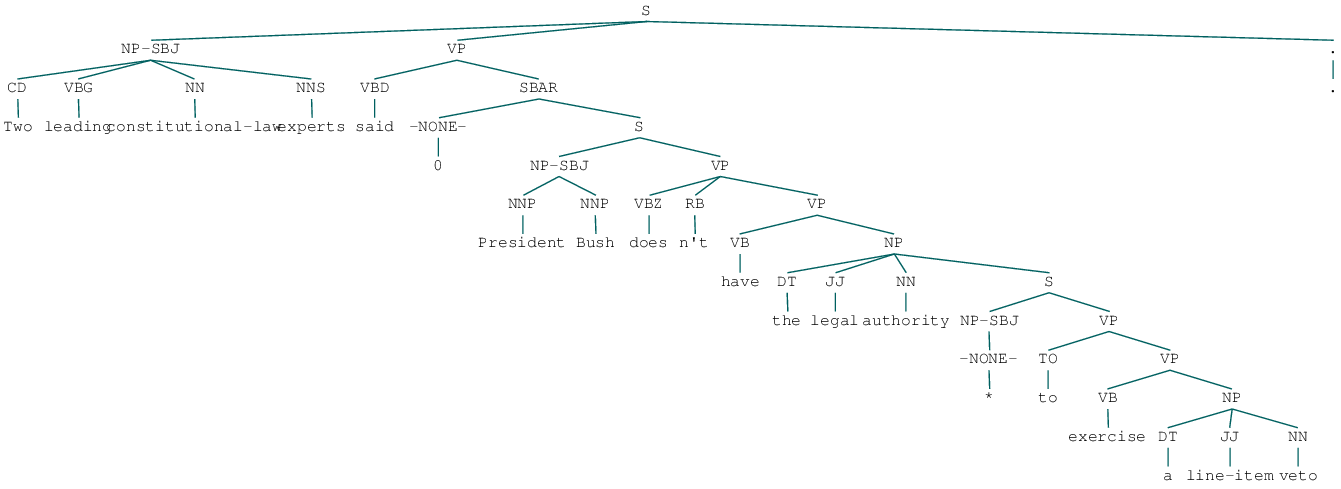

In [49]:
# You can visualise a tree as an image
dev_parses[0]

In [50]:
# and you can also visualise it as a nested bracketed string
print(dev_parses[0])

(S
  (NP-SBJ
    (CD Two)
    (VBG leading)
    (NN constitutional-law)
    (NNS experts))
  (VP
    (VBD said)
    (SBAR
      (-NONE- 0)
      (S
        (NP-SBJ (NNP President) (NNP Bush))
        (VP
          (VBZ does)
          (RB n't)
          (VP
            (VB have)
            (NP
              (DT the)
              (JJ legal)
              (NN authority)
              (S
                (NP-SBJ (-NONE- *))
                (VP
                  (TO to)
                  (VP
                    (VB exercise)
                    (NP (DT a) (JJ line-item) (NN veto)))))))))))
  (. .))


Below we convert from nltk CFG production object to our own Rule object

In [51]:
import nltk
from nltk.grammar import Nonterminal as NLTKNonterminal

def convert_nltk_rule(nltk_rule) -> Rule:   
    """Here we convert from nltk production object to our own Rule object"""
    lhs = Nonterminal(str(nltk_rule.lhs()))
    rhs = []
    for sym in nltk_rule.rhs():
        if isinstance(sym, NLTKNonterminal):
            rhs.append(Nonterminal(str(sym)))
        else:
            rhs.append(Terminal(str(sym)))
    return Rule(lhs, rhs)

Here we make a CFG by inspecting the rules used in a treebank

In [52]:
def make_cfg(parse_trees, max_arity=4, start=Nonterminal('S')):
    """
    Here we make a CFG by collecting rules used to in a treebank.
    We impose a maximum arity because some annotated rules are incredibly long!
    
    :param parse_trees: a collection of nltk trees
    :param max_arity: maximum arity we want for our grammar (we discard rules longer than this)
    :param start: the nonterminal that starts derivations in this grammar
        - Penn treebank uses S as start symbol
    :returns: a CFG object containing all rules used in parse_trees if they are not longer than what we want
    """
    cfg = CFG(start)
    for nltk_tree in parse_trees:
        for nltk_rule in nltk_tree.productions():
            rule = convert_nltk_rule(nltk_rule)
            if rule.arity <= max_arity:
                cfg.add(rule)
    return cfg

In [53]:
ptb_grammar = make_cfg(training_parses, max_arity=4)

In [54]:
print('PTB')
print(len(ptb_grammar), 'rules')
print(len(ptb_grammar.terminals), 'terminal')
print(len(ptb_grammar.nonterminals), 'nonterminal')
print(len(ptb_grammar.preterminals), 'preterminals')
print('arity', ptb_grammar.arity)

PTB
17537 rules
10779 terminal
668 nonterminal
46 preterminals
arity 4


**Implementation** Now you will implement MLE for PCFGs with lexical smoothing.

<a name="ex6-11" style="color:red">**Exercise 6-11**</a> **[4 points]** MLE for PCFGs

* **[1 point]** Start by implementing `count_rules` below to gather counts from the data. Organise counts in a data structure similar to our $P_R$ in `get_toy_pcfg`, that is, a dictionary of dictionaries where the outer dict maps LHS to Rule objects, the inner dict maps from a Rule object to its count in the data.
* **[1 point]** Implement Laplace smoothing for pre-terminal rules in `add_pseudo_counts_and_unk_rules`
* **[1 point]** Estimate MLE parameters using the treebank `training_parses` above (first 3000 examples of NLTK's PTB data), and save your MLE solutions to a file where each line contains ```PROB LHS -> RHS```, make sure your file is sorted by LHS (lexicographically) and then by probability value (best first). Example:

```
0.6 NP -> N
0.4 NP -> D N
0.9 S -> NP VP
0.1 S -> VP
0.5 VP -> V
0.5 VP -> VP VP
```
* **[1 point]** Show examples of string generated by sampling from the grammar using the function `generate_sample` you implemented earlier. 


In [55]:
def count_rules(parse_trees):
    """
    Gather counts necessary for MLE.
    :param parse_trees: a collection of nltk parse trees
        - TIP: use the convertion function we provided
    :returns: counts as a dictionary of dictionaries mapping from LHS to RULE to count
    """
    # TYPE YOUR SOLUTION
    pass

In [56]:
#joint_counts = count_rules(training_parses)

In [57]:
def add_pseudo_counts_and_unk_rules(cfg: CFG, joint_counts, alpha: float, unk_str='<unk>'):
    """
    Add pseudo counts for Laplace smoothing of pre-terminal rules.
    
    This function should update `joint_counts` with pseudo counts whenever appropriate.
    Recall that you have to create an unk Terminal and you have to add unk rules to the grammar.    
    
    :param cfg: CFG
    :param joint_counts: dictionary of dictionaries from `count_rules` above where
        joint_counts[X][r] is the count of a rule r whose LHS is X
    :param alpha: Laplace smoothing constant
    :param unk_str: the string for unknown terminals
    """
    # TYPE YOUR SOLUTION
    pass

In [62]:
# Try the following
# add_pseudo_counts_and_unk_rules(ptb_grammar, joint_counts, 1.)

In [59]:
def compute_maximum_likelihood_estimates(cfg: CFG, joint_counts):
    """
    Use the gathered counts to compute the maximum likelihood estimates.
    
    :param cfg: a CFG object
    :param joint_counts: counts as computed by `count_rules` and smoothed by `add_pseudo_counts_and_unk_rules`
    :returns: cpds as a dictionary of dictionaries where
        cpds[X][r] is the MLE parameter for rule r whose LHS is X
    """
    # TYPE YOUR SOLUTION
    pass

In [61]:
# Try the following
# p_R = compute_maximum_likelihood_estimates(ptb_grammar, joint_counts)